## 輪郭抽出

In [1]:
import os
import kkg_area_detection
from PIL import Image
from typing import List, Literal

### Initialization

In [2]:
DIR_SANDBOX = os.path.abspath(".")
DIR_MODEL = os.path.join(DIR_SANDBOX, "../model/mask2former_trained/")
IMG_SAMPLE = os.path.join(DIR_SANDBOX, "./sample_image.jpg")

In [3]:
kkg_area_detection.initialize_model(
    model_path=DIR_MODEL,
    use_default_local_path=False, # Important: Don't use default path
    # device="cuda" # Uncomment if GPU is available and desired
)

Loaded model from specified path: /Users/iwasakishuto/Github/KKG/kkg-area-detection/sandbox/../model/large_20/
Model loaded on device: cpu


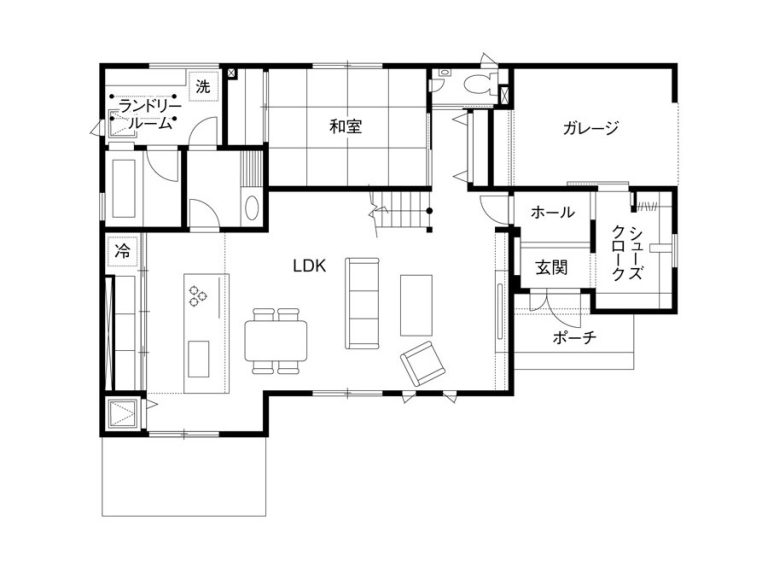

In [4]:
## Sample Image
image = Image.open(IMG_SAMPLE)
image

### Segmentation

In [5]:
def concat_images(
    images: List[Image.Image],
    direction: Literal["vertical", "horizontal"] = "vertical",
    bg_color=(255, 255, 255)
) -> Image.Image:
    if direction == "vertical":
        max_width = max(img.width for img in images)
        total_height = sum(img.height for img in images)
        new_image = Image.new("RGB", (max_width, total_height), color=bg_color)

        y_offset = 0
        for img in images:
            new_image.paste(img, (0, y_offset))
            y_offset += img.height

    elif direction == "horizontal":
        total_width = sum(img.width for img in images)
        max_height = max(img.height for img in images)
        new_image = Image.new("RGB", (total_width, max_height), color=bg_color)

        x_offset = 0
        for img in images:
            new_image.paste(img, (x_offset, 0))
            x_offset += img.width
    else:
        raise ValueError("direction must be 'vertical' or 'horizontal'")

    return new_image

In [6]:
segmentation_result = kkg_area_detection.get_segmentation_result(image)

In [7]:
hasattr(kkg_area_detection, 'extract_regions_from_segmentation')

False

In [8]:
if hasattr(kkg_area_detection, 'extract_regions_from_segmentation'):
    regions_for_viz = kkg_area_detection.extract_regions_from_segmentation(segmentation_result)
else:
    regions_for_viz = segmentation_result.get('segments_info', [])    

In [9]:
visualized_image = kkg_area_detection.visualize_regions(
    image,
    regions_for_viz, # Use extracted regions/segments
    alpha=0.5, # Use desired transparency
    color_map=None, # Random colors
    segmentation_result=segmentation_result
)

Converting negative values in segmentation map...


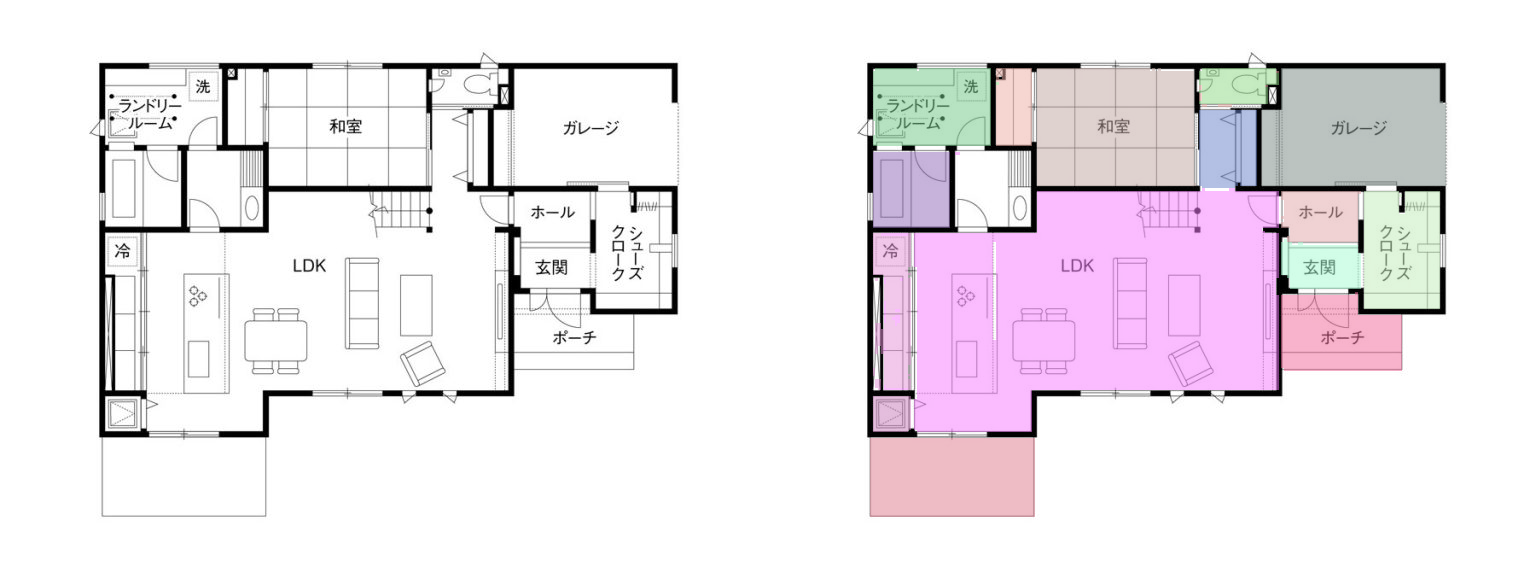

In [10]:
concat_images(images=[image, visualized_image], direction="horizontal")

### 輪郭抽出

In [11]:
epsilon = 0.015
smoothing_kernel_size=5
smoothing_iterations=1
min_angle=30.0

In [12]:
segmentation_map = segmentation_result["segmentation"].cpu().numpy()

In [13]:
# 元の輪郭（近似なし）
original_contours = kkg_area_detection.get_approx_contours_and_vertices(segmentation_map, epsilon=0)
original_image = kkg_area_detection.visualize_contours(image=image, contours_list=original_contours)

# 輪郭近似を適用
approximated_contours = kkg_area_detection.get_approx_contours_and_vertices(segmentation_map, epsilon=epsilon)
approximated_image = kkg_area_detection.visualize_contours(image=image, contours_list=approximated_contours)

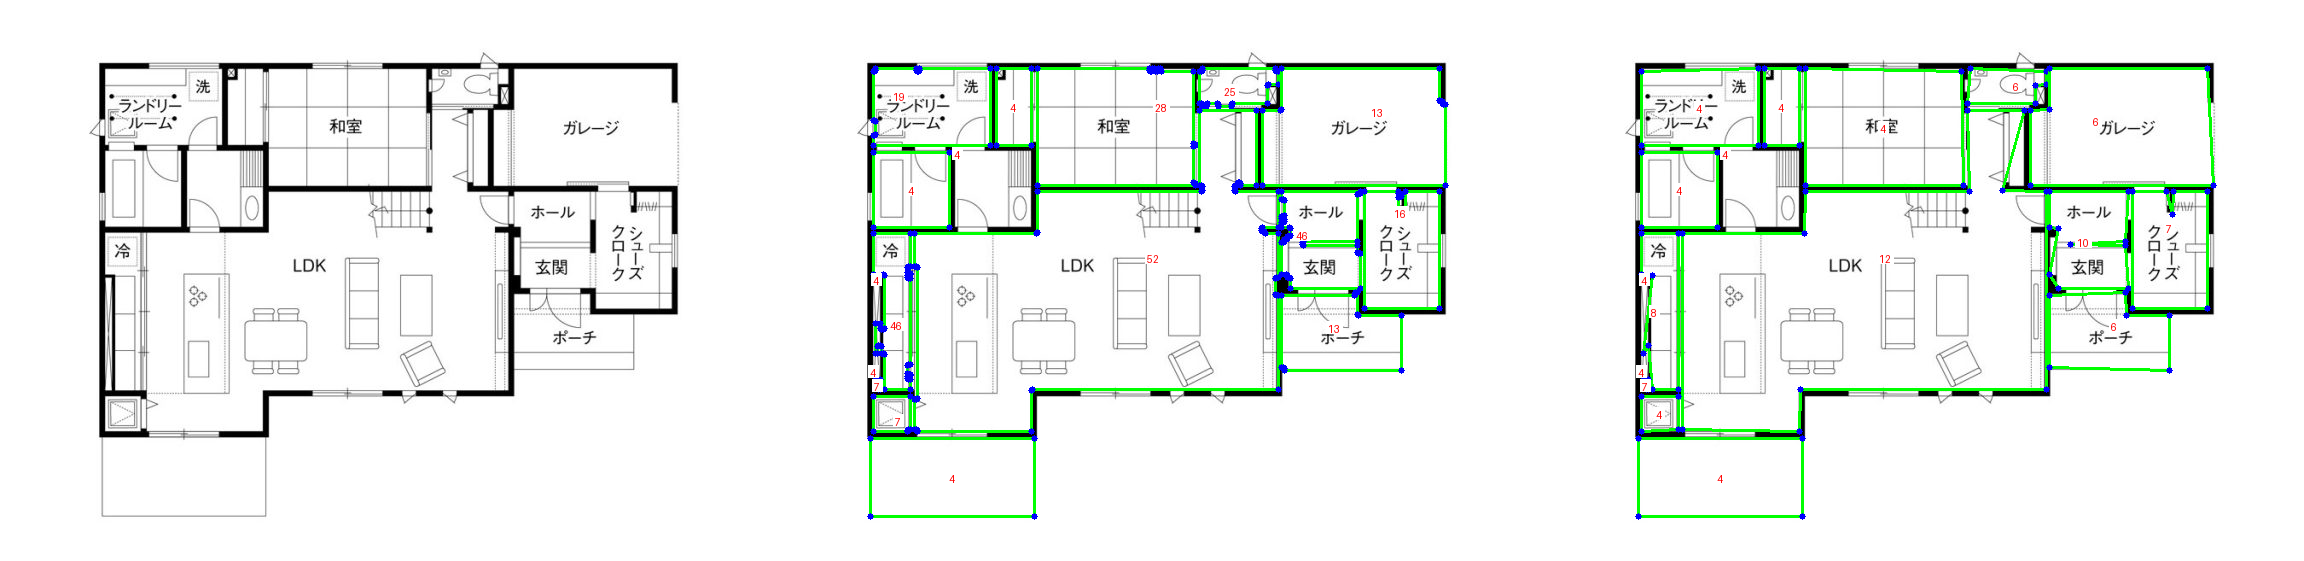

In [14]:
concat_images(images=[image, original_image, approximated_image], direction="horizontal")

In [15]:
# スムージングを適用した輪郭近似
smoothed_contours = kkg_area_detection.get_approx_contours_and_vertices(
    segmentation_map,
    epsilon=epsilon,
    use_smoothing=True,
    smoothing_kernel_size=smoothing_kernel_size,
    smoothing_iterations=smoothing_iterations
)
smoothed_image = kkg_area_detection.visualize_contours(image=image, contours_list=smoothed_contours)

# 鋭角フィルタリングを適用した輪郭近似
angle_filtered_contours = kkg_area_detection.get_approx_contours_and_vertices(
    segmentation_map,
    epsilon=epsilon,
    use_angle_filter=True,
    min_angle=min_angle
)
angle_filtered_image = kkg_area_detection.visualize_contours(image=image, contours_list=angle_filtered_contours)

# スムージング＋角度フィルタリングの両方を適用
smoothed_angle_filtered_contours = kkg_area_detection.get_approx_contours_and_vertices(
    segmentation_map,
    epsilon=epsilon,
    use_smoothing=True,
    smoothing_kernel_size=smoothing_kernel_size,
    smoothing_iterations=smoothing_iterations,
    use_angle_filter=True,
    min_angle=min_angle
)
smoothed_angle_filtered_image = kkg_area_detection.visualize_contours(image=image, contours_list=smoothed_angle_filtered_contours)

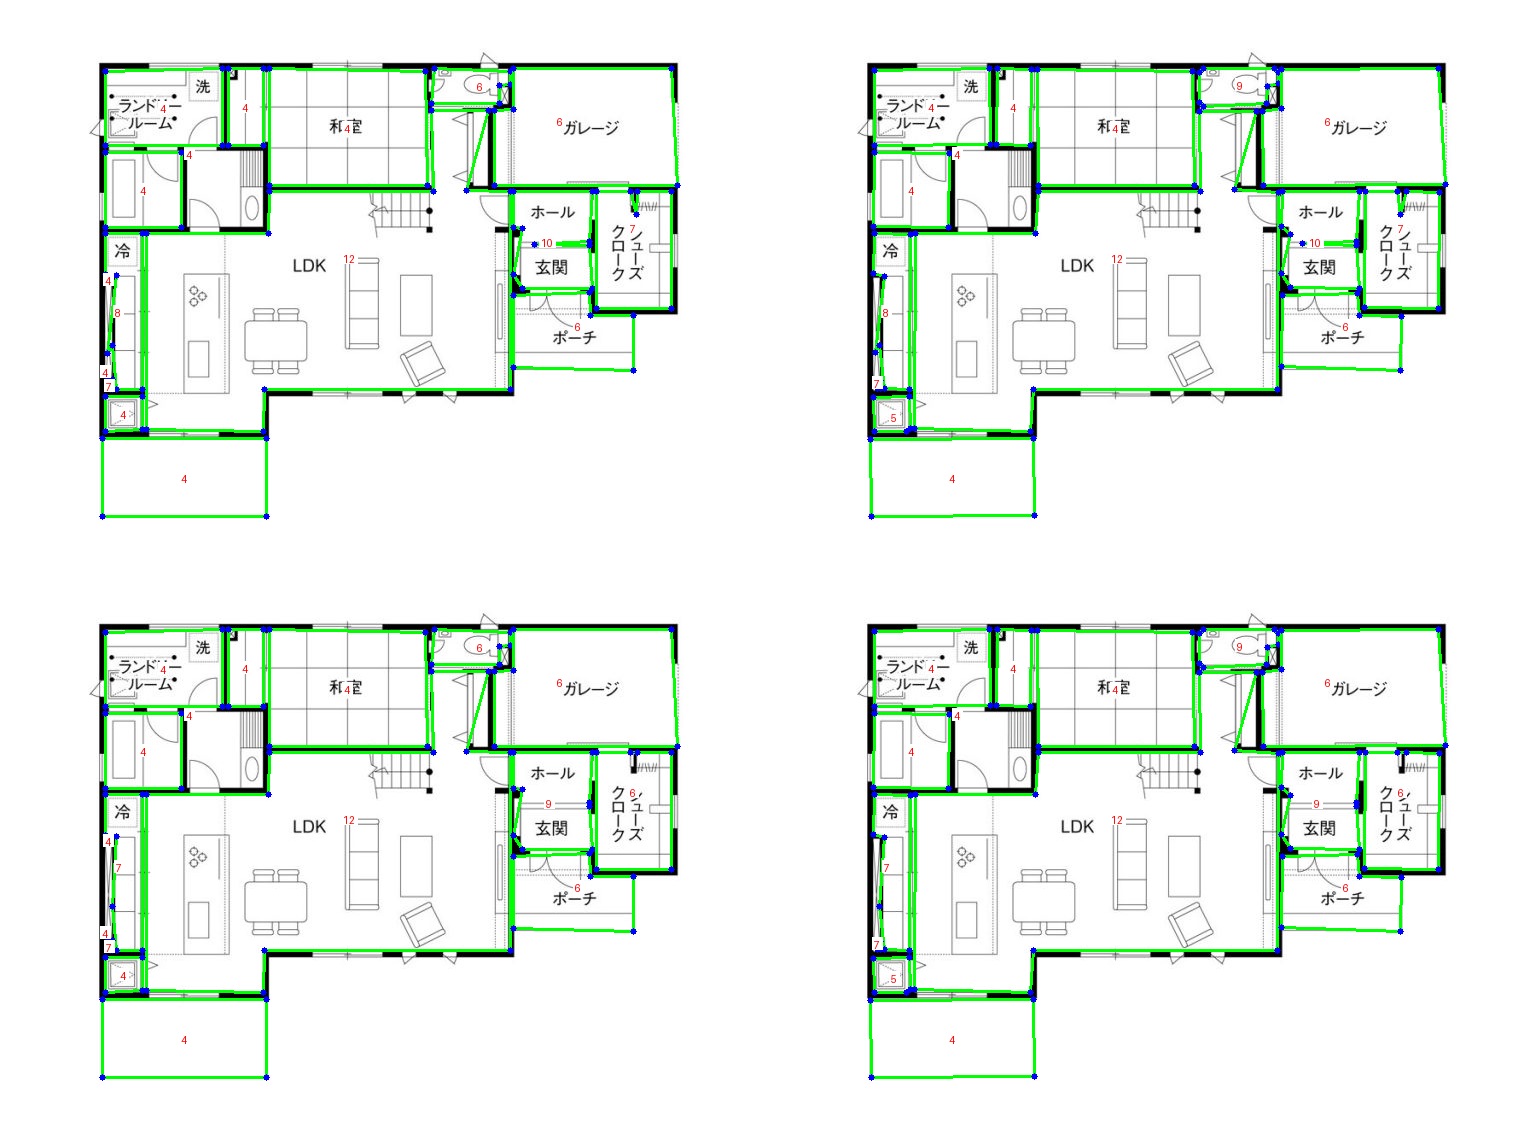

In [16]:
concat_images(
    images=[
        concat_images(images=[approximated_image, smoothed_image], direction="horizontal"),
        concat_images(images=[angle_filtered_image, smoothed_angle_filtered_image], direction="horizontal")
    ],
    direction="vertical"
)